In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from lstm_baseline import LSTMModel  
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

### Technical and Macro signals.

In [2]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',       # Federal Funds Rate
    'UNRATE',         # Unemployment Rate
    'GS10',           # 10-Year Treasury Yield
    'DTWEXBGS',       # Dollar Index
    'DCOILWTICO',     # Oil Prices
    'GOLD',           # Gold Prices
    'MOVE',           # MOVE Index
    'VIXCLS'          # Volatility Index (VIX)
]

technical_features = [
    'SMA_10',         # 10-day Simple Moving Average
    'SMA_50',         # 50-day Simple Moving Average
    'EMA_10',         # 10-day Exponential Moving Average
    'EMA_50',         # 50-day Exponential Moving Average
    'ROC_10',         # 10-day Rate of Change
    'RSI_14',         # 14-day Relative Strength Index
    'BB_upper',       # Upper Bollinger Band
    'BB_lower',       # Lower Bollinger Band
    'Volatility_20'   # 20-day Rolling Volatility
]

target = 'SP500'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


In [3]:

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [4]:
seq_length = 20

macro_scaler = MinMaxScaler()
X_macro_scaled = macro_scaler.fit_transform(X_macro)

tech_scaler = MinMaxScaler()
X_technical_scaled = tech_scaler.fit_transform(X_technical)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_macro)  

X_macro_seq, y_macro_seq = create_sequences(X_macro_scaled, y_scaled, seq_length)
X_technical_seq, y_technical_seq = create_sequences(X_technical_scaled, y_scaled, seq_length)


/var/folders/5t/_mmy5kjx1yn0xc44547b62pr0000gn/T/ipykernel_22998/1762235571.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [5]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_macro_seq, y_macro_seq)


In [6]:
input_size = X_macro_seq.shape[2]
model = LSTMModel(input_size=input_size, hidden_size=120, output_size=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

train_losses = []
val_losses = []
test_losses = []

for epoch in range(1000):
    # --- Training ---
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred.squeeze(), yb.squeeze())
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(train_loader))

    # --- Validation ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred.squeeze(), yb.squeeze()).item()
    val_losses.append(val_loss / len(val_loader))

    # --- Test ---
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            test_loss += criterion(pred.squeeze(), yb.squeeze()).item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}: Train={train_losses[-1]:.4f}, Val={val_losses[-1]:.4f}, Test={test_losses[-1]:.4f}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1: Train=0.0647, Val=0.1631, Test=0.3746
Epoch 2: Train=0.0459, Val=0.0252, Test=0.2132
Epoch 3: Train=0.0316, Val=0.0447, Test=0.2339
Epoch 4: Train=0.0108, Val=0.0399, Test=0.2000
Epoch 5: Train=0.0141, Val=0.0711, Test=0.2954
Epoch 6: Train=0.0089, Val=0.0387, Test=0.1002
Epoch 7: Train=0.0068, Val=0.0357, Test=0.1962
Epoch 8: Train=0.0041, Val=0.0339, Test=0.1614
Epoch 9: Train=0.0051, Val=0.0306, Test=0.1469
Epoch 10: Train=0.0034, Val=0.0422, Test=0.1735
Epoch 11: Train=0.0037, Val=0.0339, Test=0.1389
Epoch 12: Train=0.0040, Val=0.0277, Test=0.1373
Epoch 13: Train=0.0030, Val=0.0306, Test=0.1590
Epoch 14: Train=0.0030, Val=0.0397, Test=0.1671
Epoch 15: Train=0.0035, Val=0.0426, Test=0.1703
Epoch 16: Train=0.0028, Val=0.0303, Test=0.1640
Epoch 17: Train=0.0025, Val=0.0387, Test=0.1729
Epoch 18: Train=0.0019, Val=0.0321, Test=0.1949
Epoch 19: Train=0.0034, Val=0.0398, Test=0.1982
Epoch 20: Train=0.0027, Val=0.0506, Test=0.1900
Epoch 21: Train=0.0028, Val=0.0329, Test=0.1886
E

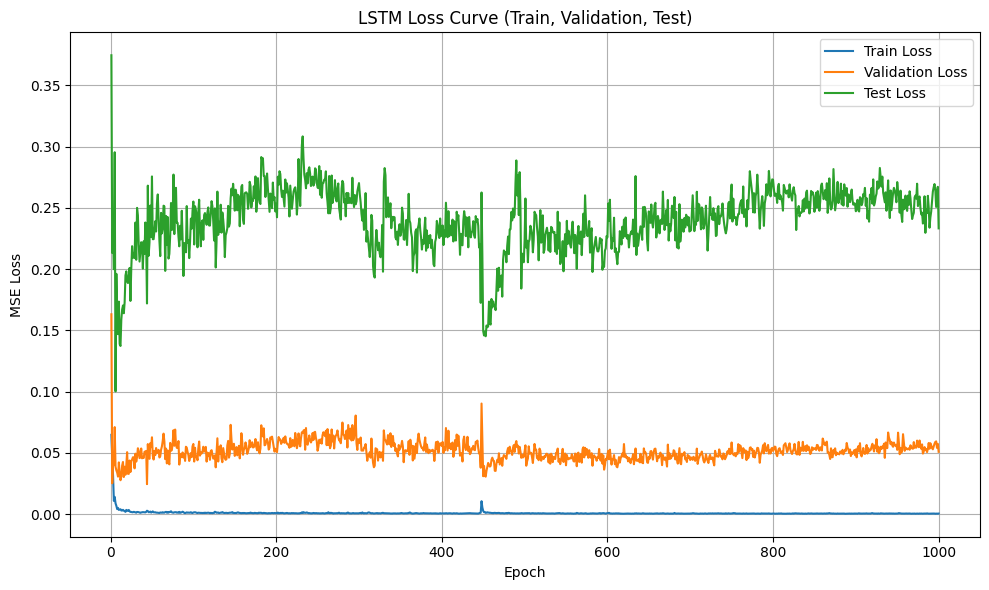

In [7]:

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss')

plt.title("LSTM Loss Curve (Train, Validation, Test)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



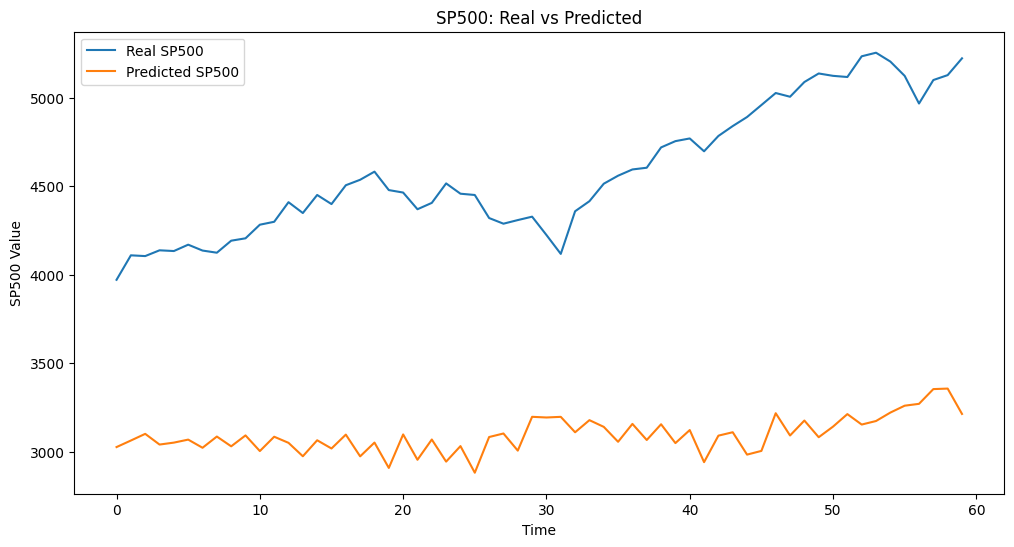

In [8]:
# Get predictions from the model
model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()

# Inverse transform to get real SP500 values
sp500_real = y_scaler.inverse_transform(y_test.cpu().numpy())
sp500_pred = y_scaler.inverse_transform(preds)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sp500_real, label='Real SP500')
plt.plot(sp500_pred, label='Predicted SP500')
plt.title('SP500: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('SP500 Value')
plt.legend()
plt.show()

In [9]:

real = sp500_real.flatten()
pred = sp500_pred.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))

# Compare direction: 1 if correct, 0 otherwise
directional_accuracy = np.mean(real_diff == pred_diff)

print(f"Directional Accuracy: {directional_accuracy:.2%}")


Directional Accuracy: 50.85%


Epoch 1: Train=0.0516, Val=0.0331, Test=0.1037
Epoch 2: Train=0.0119, Val=0.0286, Test=0.0079
Epoch 3: Train=0.0058, Val=0.0361, Test=0.0095
Epoch 4: Train=0.0058, Val=0.0039, Test=0.0222
Epoch 5: Train=0.0040, Val=0.0199, Test=0.0093
Epoch 6: Train=0.0028, Val=0.0120, Test=0.0069
Epoch 7: Train=0.0044, Val=0.0128, Test=0.0083
Epoch 8: Train=0.0035, Val=0.0588, Test=0.0180
Epoch 9: Train=0.0038, Val=0.0047, Test=0.0202
Epoch 10: Train=0.0024, Val=0.0109, Test=0.0070
Epoch 11: Train=0.0027, Val=0.0107, Test=0.0106
Epoch 12: Train=0.0022, Val=0.0259, Test=0.0069
Epoch 13: Train=0.0020, Val=0.0051, Test=0.0139
Epoch 14: Train=0.0020, Val=0.0155, Test=0.0072
Epoch 15: Train=0.0019, Val=0.0155, Test=0.0066
Epoch 16: Train=0.0016, Val=0.0197, Test=0.0060
Epoch 17: Train=0.0014, Val=0.0075, Test=0.0091
Epoch 18: Train=0.0018, Val=0.0102, Test=0.0080
Epoch 19: Train=0.0019, Val=0.0052, Test=0.0081
Epoch 20: Train=0.0018, Val=0.0048, Test=0.0090
Epoch 21: Train=0.0023, Val=0.0057, Test=0.0082
E

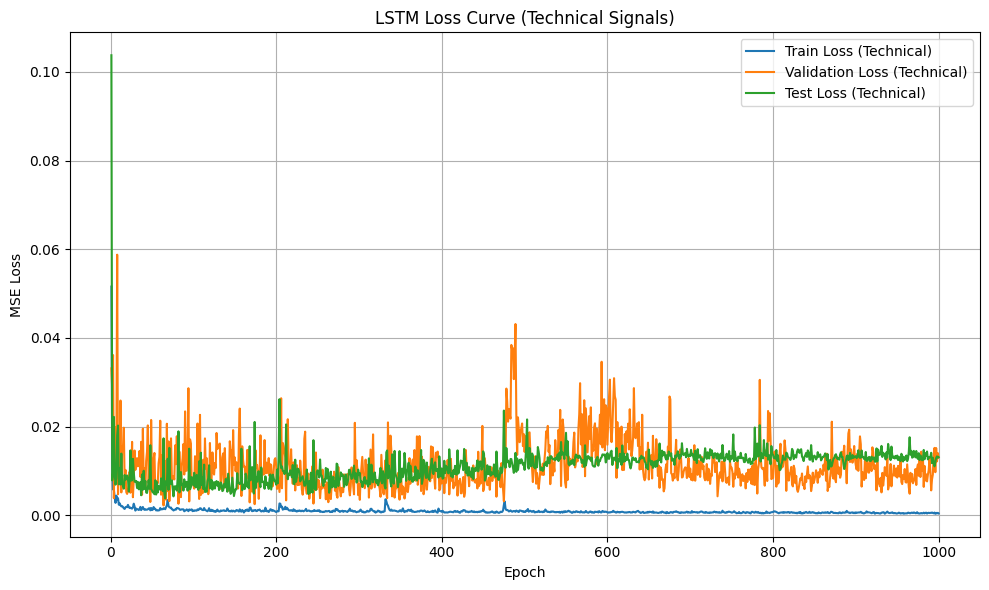

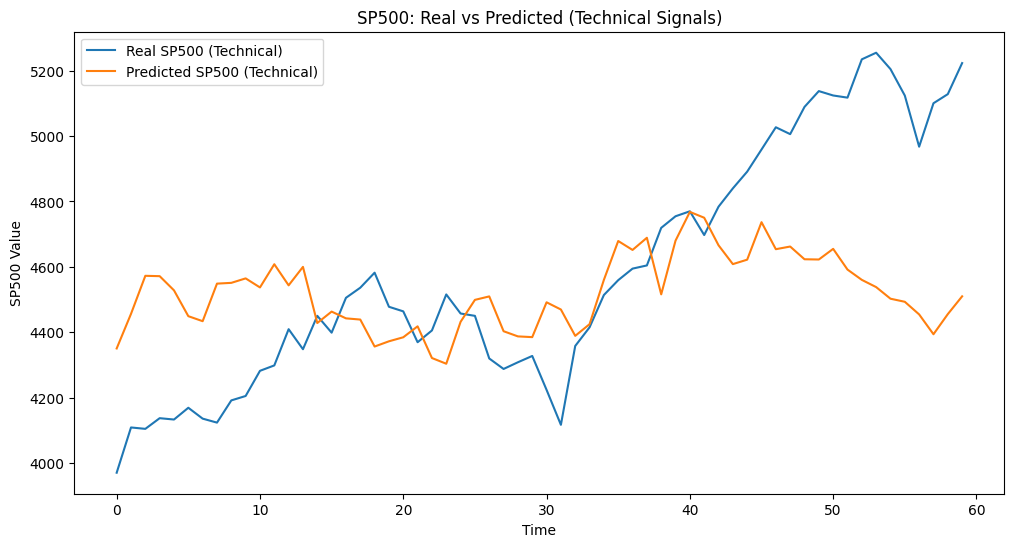

Directional Accuracy (Technical): 38.98%


In [10]:
# Prepare train/val/test splits for technical signals
X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t = train_val_test_split(X_technical_seq, y_technical_seq)

# Define and train a new LSTM model for technical signals
input_size_t = X_technical_seq.shape[2]
model_t = LSTMModel(input_size=input_size_t, hidden_size=120, output_size=1)

criterion_t = nn.MSELoss()
optimizer_t = torch.optim.Adam(model_t.parameters(), lr=0.01)

train_losses_t = []
val_losses_t = []
test_losses_t = []

train_loader_t = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=16, shuffle=True)
val_loader_t = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=16)
test_loader_t = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=16, shuffle=False)

for epoch in range(1000):
    # --- Training ---
    model_t.train()
    total_train_loss_t = 0
    for xb, yb in train_loader_t:
        optimizer_t.zero_grad()
        pred = model_t(xb)
        loss = criterion_t(pred.squeeze(), yb.squeeze())
        loss.backward()
        optimizer_t.step()
        total_train_loss_t += loss.item()
    train_losses_t.append(total_train_loss_t / len(train_loader_t))

    # --- Validation ---
    model_t.eval()
    val_loss_t = 0
    with torch.no_grad():
        for xb, yb in val_loader_t:
            pred = model_t(xb)
            val_loss_t += criterion_t(pred.squeeze(), yb.squeeze()).item()
    val_losses_t.append(val_loss_t / len(val_loader_t))

    # --- Test ---
    test_loss_t = 0
    with torch.no_grad():
        for xb, yb in test_loader_t:
            pred = model_t(xb)
            test_loss_t += criterion_t(pred.squeeze(), yb.squeeze()).item()
    test_losses_t.append(test_loss_t / len(test_loader_t))

    print(f"Epoch {epoch+1}: Train={train_losses_t[-1]:.4f}, Val={val_losses_t[-1]:.4f}, Test={test_losses_t[-1]:.4f}")

# Plot loss curves for technical signals
epochs_t = list(range(1, len(train_losses_t) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs_t, train_losses_t, label='Train Loss (Technical)')
plt.plot(epochs_t, val_losses_t, label='Validation Loss (Technical)')
plt.plot(epochs_t, test_losses_t, label='Test Loss (Technical)')
plt.title("LSTM Loss Curve (Technical Signals)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get predictions from the technical model
model_t.eval()
with torch.no_grad():
    preds_t = model_t(X_test_t).cpu().numpy()

sp500_real_t = y_scaler.inverse_transform(y_test_t.cpu().numpy())
sp500_pred_t = y_scaler.inverse_transform(preds_t)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real_t, label='Real SP500 (Technical)')
plt.plot(sp500_pred_t, label='Predicted SP500 (Technical)')
plt.title('SP500: Real vs Predicted (Technical Signals)')
plt.xlabel('Time')
plt.ylabel('SP500 Value')
plt.legend()
plt.show()

real_t = sp500_real_t.flatten()
pred_t = sp500_pred_t.flatten()
real_diff_t = np.sign(np.diff(real_t))
pred_diff_t = np.sign(np.diff(pred_t))
directional_accuracy_t = np.mean(real_diff_t == pred_diff_t)
print(f"Directional Accuracy (Technical): {directional_accuracy_t:.2%}")

Epoch 1: Train=0.0668, Val=0.0045, Test=0.0275
Epoch 2: Train=0.0152, Val=0.0102, Test=0.0623
Epoch 3: Train=0.0105, Val=0.0147, Test=0.0671
Epoch 4: Train=0.0049, Val=0.0182, Test=0.0089
Epoch 5: Train=0.0058, Val=0.0428, Test=0.0039
Epoch 6: Train=0.0127, Val=0.0118, Test=0.0195
Epoch 7: Train=0.0036, Val=0.0122, Test=0.0122
Epoch 8: Train=0.0025, Val=0.0077, Test=0.0287
Epoch 9: Train=0.0016, Val=0.0080, Test=0.0279
Epoch 10: Train=0.0016, Val=0.0062, Test=0.0245
Epoch 11: Train=0.0014, Val=0.0083, Test=0.0329
Epoch 12: Train=0.0019, Val=0.0058, Test=0.0227
Epoch 13: Train=0.0020, Val=0.0062, Test=0.0146
Epoch 14: Train=0.0028, Val=0.0139, Test=0.0638
Epoch 15: Train=0.0024, Val=0.0101, Test=0.0093
Epoch 16: Train=0.0016, Val=0.0058, Test=0.0149
Epoch 17: Train=0.0013, Val=0.0052, Test=0.0267
Epoch 18: Train=0.0013, Val=0.0105, Test=0.0080
Epoch 19: Train=0.0012, Val=0.0052, Test=0.0249
Epoch 20: Train=0.0015, Val=0.0068, Test=0.0130
Epoch 21: Train=0.0012, Val=0.0062, Test=0.0195
E

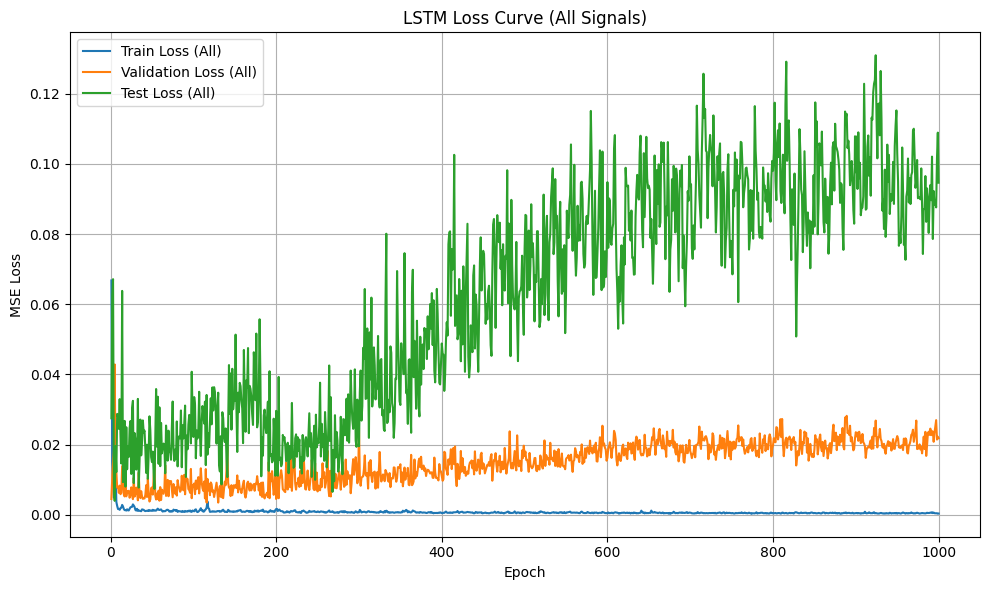

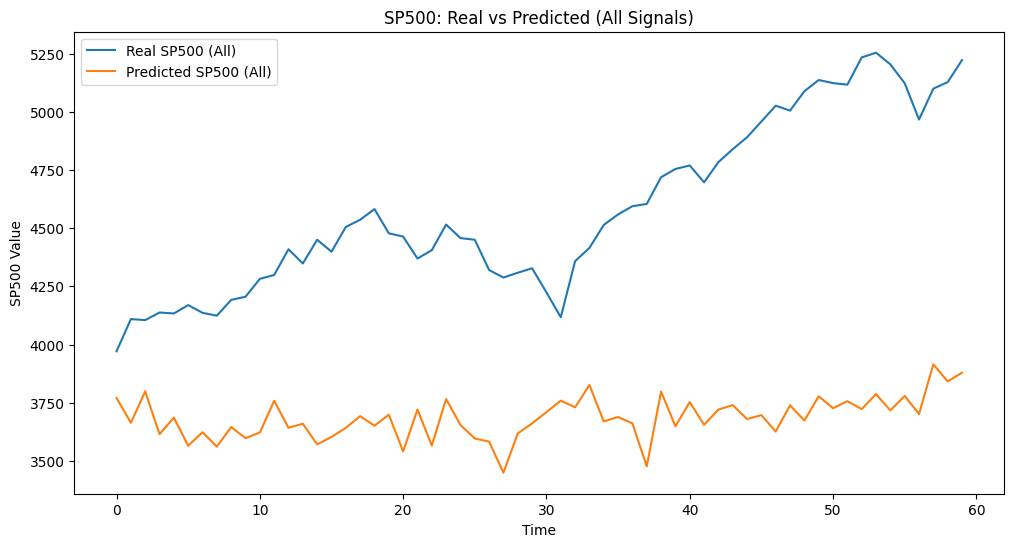

Directional Accuracy (All): 49.15%


In [11]:
features = macro_features + technical_features
X_all = df[features].values
scaler_all = MinMaxScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

X_all_seq, y_all_seq = create_sequences(X_all_scaled, y_scaled, seq_length)
X_train_all, y_train_all, X_val_all, y_val_all, X_test_all, y_test_all = train_val_test_split(X_all_seq, y_all_seq)


# Define and train a new LSTM model for all signals
input_size_all = X_all_seq.shape[2]
model_all = LSTMModel(input_size=input_size_all, hidden_size=120, output_size=1)

criterion_all = nn.MSELoss()
optimizer_all = torch.optim.Adam(model_all.parameters(), lr=0.01)

train_losses_all = []
val_losses_all = []
test_losses_all = []

train_loader_all = DataLoader(TensorDataset(X_train_all, y_train_all), batch_size=16, shuffle=True)
val_loader_all = DataLoader(TensorDataset(X_val_all, y_val_all), batch_size=16)
test_loader_all = DataLoader(TensorDataset(X_test_all, y_test_all), batch_size=16, shuffle=False)

for epoch in range(1000):
    # --- Training ---
    model_all.train()
    total_train_loss_all = 0
    for xb, yb in train_loader_all:
        optimizer_all.zero_grad()
        pred = model_all(xb)
        loss = criterion_all(pred.squeeze(), yb.squeeze())
        loss.backward()
        optimizer_all.step()
        total_train_loss_all += loss.item()
    train_losses_all.append(total_train_loss_all / len(train_loader_all))

    # --- Validation ---
    model_all.eval()
    val_loss_all = 0
    with torch.no_grad():
        for xb, yb in val_loader_all:
            pred = model_all(xb)
            val_loss_all += criterion_all(pred.squeeze(), yb.squeeze()).item()
    val_losses_all.append(val_loss_all / len(val_loader_all))

    # --- Test ---
    test_loss_all = 0
    with torch.no_grad():
        for xb, yb in test_loader_all:
            pred = model_all(xb)
            test_loss_all += criterion_all(pred.squeeze(), yb.squeeze()).item()
    test_losses_all.append(test_loss_all / len(test_loader_all))

    print(f"Epoch {epoch+1}: Train={train_losses_all[-1]:.4f}, Val={val_losses_all[-1]:.4f}, Test={test_losses_all[-1]:.4f}")

# Plot loss curves for all signals
epochs_all = list(range(1, len(train_losses_all) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs_all, train_losses_all, label='Train Loss (All)')
plt.plot(epochs_all, val_losses_all, label='Validation Loss (All)')
plt.plot(epochs_all, test_losses_all, label='Test Loss (All)')
plt.title("LSTM Loss Curve (All Signals)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get predictions from the all-signals model
model_all.eval()
with torch.no_grad():
    preds_all = model_all(X_test_all).cpu().numpy()

sp500_real_all = y_scaler.inverse_transform(y_test_all.cpu().numpy())
sp500_pred_all = y_scaler.inverse_transform(preds_all)

plt.figure(figsize=(12, 6))
plt.plot(sp500_real_all, label='Real SP500 (All)')
plt.plot(sp500_pred_all, label='Predicted SP500 (All)')
plt.title('SP500: Real vs Predicted (All Signals)')
plt.xlabel('Time')
plt.ylabel('SP500 Value')
plt.legend()
plt.show()

real_all = sp500_real_all.flatten()
pred_all = sp500_pred_all.flatten()
real_diff_all = np.sign(np.diff(real_all))
pred_diff_all = np.sign(np.diff(pred_all))
directional_accuracy_all = np.mean(real_diff_all == pred_diff_all)
print(f"Directional Accuracy (All): {directional_accuracy_all:.2%}")